# Install Libraries

In [23]:
#use the following line to install the required libraries if needed
#pip install '...'

# ! pip install fairlearn
# ! pip install dalex -U
# ! pip install -U scikit-learn
# ! pip install -U pandas
# ! pip install -U aif360 
# ! pip install -U plotly

# Import Libraries

In [24]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn
import dalex as dx

from copy import copy

from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

{
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "matplotlib": matplotlib.__version__,
    "seaborn": sns.__version__,
    "sklearn": sklearn.__version__,
    "dalex": dx.__version__,
}

{'numpy': '2.2.6',
 'pandas': '2.3.1',
 'matplotlib': '3.10.5',
 'seaborn': '0.13.2',
 'sklearn': '1.7.1',
 'dalex': '1.7.2'}

In [25]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [26]:
sklearn.set_config(display="diagram")

## Bias a priori

*When implementing an AI system, fairness and biases must be an important component during conception, especially when dealing with sensitive information, and/or Personally Identifiable Information (PII), and/or Personal Health Information (PHI). Indeed, not only those information are bound to the law (e.g., GDPR in Europe), but they are also bound to a brand image challenge.*

Today's example aims at **assigning a risk with recruitment data**.

Before implementing any AI system to predict the likelihood of a candidate to be hired, **AI engineers AND business stakeholders** should:

- Sit and identify potential sources of biases
- Define one or several metrics that will quantify the bias of the AI system

![fairness_tree](../../images/fairness_tree.png)

## Dataset

StackOverflow's annual user-generated survey (over 70,000 responses from over 180 countries) of developers examines all aspects of the developer experience, from learning code to preferred technologies, version control and work experience.

From the survey results, we have built a dataset with the following columns:
- **Age**: age of the applicant, >35 years old or <35 years old *(categorical)*
- **EdLevel**: education level of the applicant (Undergraduate, Master, PhD...) *(categorical)*
- **Gender**: gender of the applicant, (Man, Woman, or NonBinary) *(categorical)*
- **MainBranch**: whether the applicant is a profesional developer *(categorical)*
- **YearsCode**: how long the applicant has been coding *(integer)*
- **YearsCodePro**: how long the applicant has been coding in a professional context, *(integer)*
- **PreviousSalary**: the applicant's previous job salary *(float)*
- **ComputerSkills**: number of computer skills known by the applicant *(integer)*
- **Employed**: target variable, whether the applicant has been hired *(categorical)*


In [27]:
df = pd.read_csv("./stackoverflow_full.csv", index_col=0)
target = "Employed"

## Exploratory Data Analysis

#### Visualization of data columns

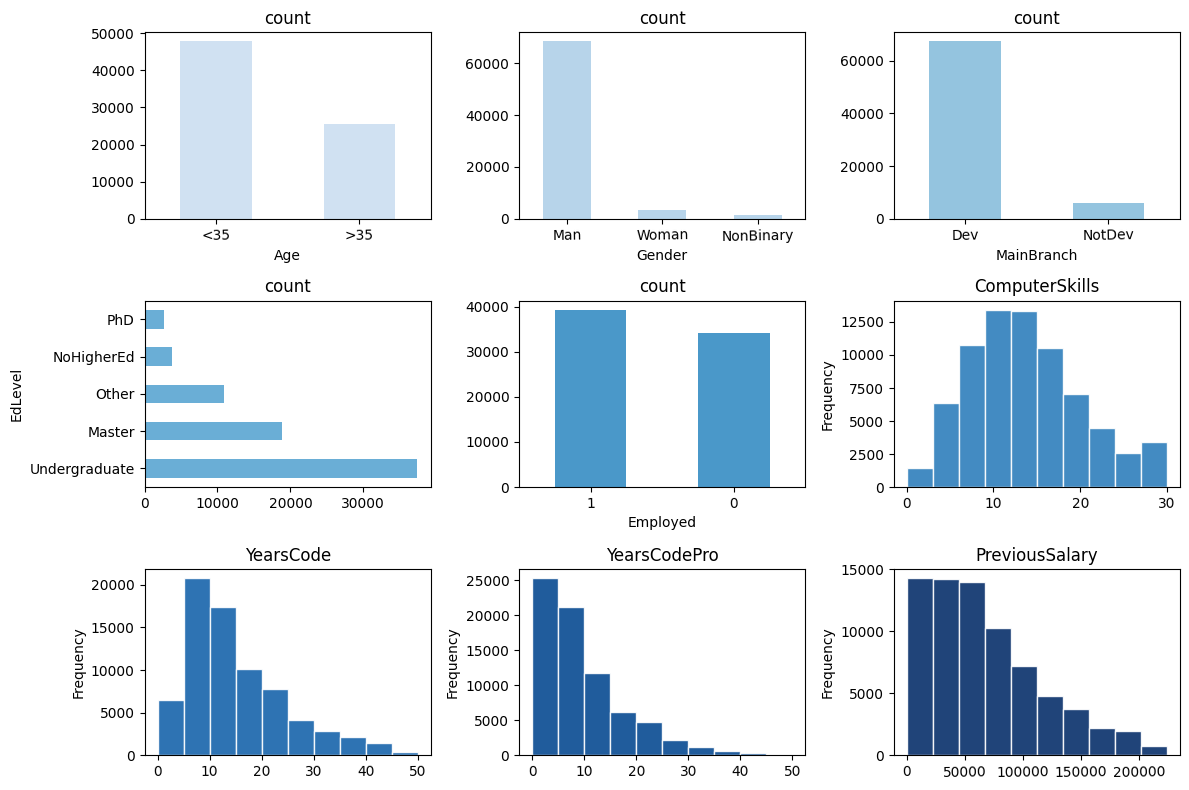

In [28]:
cmap = matplotlib.cm.Blues  # each subplot has its own blue color

fig, ax = plt.subplots(3,3, figsize=(12,8))

# Age
_ = df.Age.value_counts().plot.bar(subplots=True,
                                   ax=ax[0, 0],
                                   rot=1,
                                   color=cmap(0.2))
# Gender
_ = df.Gender.value_counts().plot.bar(subplots=True,
                                      ax=ax[0, 1],
                                      rot=1,
                                      color=cmap(0.3))
# MainBranch
_ = df.MainBranch.value_counts().plot.bar(subplots=True,
                                          ax=ax[0, 2],
                                          rot=1,
                                          color=cmap(0.4))
# EdLevel
_ = df.EdLevel.value_counts().plot.barh(subplots=True,
                                        ax=ax[1, 0],
                                        color=cmap(0.5))

# Employed
_ = df.Employed.value_counts().plot.bar(subplots=True,
                                        ax=ax[1, 1],
                                        rot=1,
                                        color=cmap(0.6))

# ComputerSkills
_ = df.ComputerSkills.clip(None, 30).plot.hist(subplots=True,
                                               ax= ax[1, 2],
                                               rot=1,
                                               color=cmap(0.7), 
                                               alpha=0.9, 
                                               edgecolor='w')

ax[1, 2].title.set_text('ComputerSkills')

# YearsCode
_ = df.YearsCode.plot.hist(subplots=True,
                                ax= ax[2, 0],
                                rot=1,
                                color=cmap(0.8),
                                alpha=0.9, 
                                edgecolor='w')

ax[2, 0].title.set_text('YearsCode')

# YearsCodePro
_ = df.YearsCodePro.plot.hist(subplots=True,
                              ax= ax[2, 1],
                              rot=1,
                              color=cmap(0.9),
                              alpha=0.9, 
                              edgecolor='w')

ax[2, 1].title.set_text('YearsCodePro')

# PreviousSalary
_ = df.PreviousSalary.plot.hist(subplots=True,
                                ax= ax[2, 2],
                                rot=1,
                                color=cmap(1.0),
                                alpha=0.9, 
                                edgecolor='w')

ax[2, 2].title.set_text('PreviousSalary')

fig.tight_layout()

#### Visualization of outliers

In [ ]:
sns.boxplot(data = df[["column1", "column2", "column3"]], palette=[cmap(0.7), cmap(0.8), cmap(0.9)]);

#### Visualization of bias on Employed

After analysing the graphs above, what bias can you identify ?

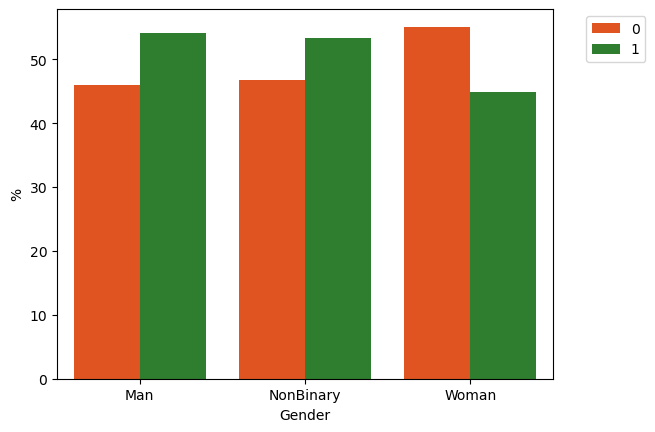

In [ ]:
"""var = (df
 .groupby("Bias")[target]
 .value_counts(normalize=True)
 .multiply(100)
 .round(1)
 .rename("%")
 .reset_index()
)

ax = sns.barplot(data=var, ci=None, x="Bias", y="%", hue="Employed", palette=["orangered", "forestgreen"])
ax.legend(bbox_to_anchor=(1.2, 1.0))"""

If you have identify more than one bias. Could you analyse the cross-bias ?

#### Analytics on biases for Gender and Age


You were able to visualize the bias above. Now make a quick quantitative analysis of the identified bias (don't forget the cross analysis).

In [ ]:
df["Bias1"].value_counts()

In [ ]:
(df
 .groupby("Bias1")[target]
 .value_counts(normalize=True)
 .multiply(100)
 .round(1)
 .to_frame()
)

In [ ]:
pd.crosstab(df["Bias1"], df["Bias2"])

In [ ]:
(df
 .groupby(["Bias1", "Bias2"])[target]
 .value_counts(normalize=True)
 .multiply(100)
 .round(1)
 .to_frame()
)

**Quick EDA**

If we bin by bias1, we realize that :
- Under represented in volume: xxx vs. yyy   
- Biased from an employment perspective: zzz% vs. www%


**Conclusion: the a priori looks confirmed and will need to be carefully handled during modelling.**

----

**Notes**

1. This is a toy example where biases are "straightforward" and well identified as "recurrent" social biases. However, it might not always be as easy to detect them. Additional sources might come from data history, selection bias, data incompleteness, unexpected sources of bias (column/attribute), ...
2. In this example, we identified biases related to representation in volume. If we had not been exposed to such discrepencies, namely having a balanced dataset, could we have concluded that biases would have been limited while modelling? Not so sure, see [this article](https://arxiv.org/pdf/1811.08489.pdf).

## ML prerequisites

In [30]:
#split your data set in 2 parts : training and testing

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=target),
    df[target],
    test_size=0.3,
    random_state=42
)

## Modeling


##### Fairness evaluation principles

The main object of dalex is the `Explainer` container which wraps a **dataset** (features and target) and a **trained model**. 

Once the data and the model have been wrapped, one needs to fix **protected and privileged attributes**.

**Important note**: beware these choices correspond to an a priori understanding of the problem and could miss hidden flaws of the model. An interesting line of work would consist in conducting a kind of grid-search exploration for potential biases.

In [31]:
# Protected attribute is 0 if a man or non binary and 0 if a woman plus the age

protected = (pd.Series(np.where(X_test["Gender"] == "Woman", '1', '0'), index=X_test.index) 
             + '_' 
             + X_test.Age)
protected_train = (pd.Series(np.where(X_train["Gender"] == "Woman", '1', '0').astype(str), index=X_train.index) 
                   + '_' 
                   + X_train.Age)

# Privileged population is men under 35 years old
privileged = '0_<35'

### Running model with no changes

#### Training

We chose to use decision trees as the classifier for this project. However, feel free to 
- Change hyperparameters of the decision tree (typically, its depth) to optimize the accuracy and investigate whether there is a tradeoff between accuracy and fairness. 
- Try other classifiers such as random forests.


In [32]:
preprocessor = make_column_transformer(
      ("passthrough", make_column_selector(dtype_include=np.number)),
      (OneHotEncoder(handle_unknown="ignore"), make_column_selector(dtype_include=object))
)

#You can change the Decision tree hyperparameters or the classifier below

clf_decisiontree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=10, random_state=123))
])

In [33]:
# clf_decisiontree.fit(df.drop(columns=[target]), df[target])
clf_decisiontree.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('passthrough', ...), ('onehotencoder', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [34]:
# exp_decisiontree = dx.Explainer(clf_decisiontree, df.drop(columns=[target]), df[target], verbose=False)
exp_decisiontree = dx.Explainer(clf_decisiontree, X_test, y_test, verbose=True)

Preparation of a new explainer is initiated

  -> data              : 22039 rows 13 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 22039 values
  -> model_class       : sklearn.tree._classes.DecisionTreeClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x000001ACC3355120> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0, mean = 0.536, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = -0.000922, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


#### Algorithmic performance

In [35]:
exp_decisiontree.model_performance().result

,recall,precision,f1,accuracy,auc
DecisionTreeClassifier,0.804868,0.788158,0.796425,0.779845,0.860599


#### Fairness performance

Quoting Dalex' tutorial:


> The idea is that ratios between scores of privileged and unprivileged metrics should be close to 1. The closer, the fairer. To relax this criterion a little bit, it can be written more thoughtfully:

> $$ \forall i \in \{a, b, ..., z\}, \quad \epsilon < \frac{metric_i}{metric_{privileged}} < \frac{1}{\epsilon}.$$

> Where the epsilon is a value between 0 and 1, it should be a minimum acceptable value of the ratio. On default, it is 0.8, which adheres to four-fifths rule (80% rule) often looked at in hiring, for example.
"

##### Metrics used

Description of the metrics used for the fairness performance evaluation of each strategys:



- **Equal opportunity ratio** computed from True positive rate (recall)

> This number describes the proportions of correctly classified positive instances.

> $TPR = \frac{TP}{P}$

- **Predictive parity ratio** computed from Positive predicted value (precision)

> This number describes the ratio of samples which were correctly classified as positive from all the positive predictions.

> $PPV = \frac{TP}{TP + FP}$

- **Accuracy equality ratio** computed from Accuracy

> This number is the ratio of the correctly classified instances (positive and negative) of all decisions.

> $ACC = \frac{TP + TN}{TP + FP + TN + FN}$

- **Predictive equality ratio** computed from False positive rate

> This number describes the share the proportion of actual negatives which was falsely classified as positive.

> $FPR = \frac{FP}{TP + TN}$

- **Statistical parity ratio** computed from Positive rate

> This number is the overall rate of positively classified instances, including both correct and incorrect decisions.

> $PR = \frac{TP + FP}{TP + FP + TN + FN}$

**Notes**:
1. Fairness metrics work the exact same way as performance metrics do. If one was to fit a model on the entire dataset and foster overfitting (namely, skipping a `train_test_split` operation), she would end up with a non biased model.
2. A lots of metrics can be computed. It is important to define early in the conception which are the critical metrics to monitor

The method `model_fairness` returns a fairness object from which fairness evaluations can be conducted. Notice that every metrics inherited from the confusion matrix are computed during the instantiation.

Two methods can then be performed:
- The `fairness_check` method, which returns a report on the fairness of the model. It requires an epsilon parameter that corresponds to the threshold ratio below which a given metric is considered to be unfair (default value is 0.8).
- The `plot` method, which allows to visualize the main fairness ratios between the protected subgroups and the privileged one.

In [36]:
fairness_decisiontree = exp_decisiontree.model_fairness(protected=protected, privileged=privileged)

In [37]:
fairness_decisiontree.fairness_check(epsilon = 0.8) # default epsilon

Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on '0_<35'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
            TPR       ACC       PPV       FPR       STP
0_>35  0.969325  0.989770  0.982346  0.942085  0.937943
1_<35  0.947239  1.006394  0.979823  0.768340  0.833333
1_>35  0.900613  1.046036  1.034048  0.459459  0.673759


In [38]:
fairness_decisiontree.plot(verbose=False)

What can you tell from these fairness evaluation results?

## Strategy choice


After the data exploration, and the cognition of the bias, you should choose which strategy to implement to mitigate the bias.
Can you think of a strategy ? 

You can call your supervisor to discuss about your idea and start the second part of this challenge.

For the selected strategy, you will have to follow the related part of the code to apply the solution and to measure the algorithmic and fairness performance of this solution. 
Based on the result, you will decide to choose the solution or not, based on :
- Its algorithmic performance
- Its fairness score
- Your interpretation of these metrics and additional solution you can think of based on those
- Its economic benefit / loss fot the company
